In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score

#### Îç∞Ïù¥ÌÑ∞ Î°úÎìú

In [3]:
file = open("/content/drive/MyDrive/Colab Notebooks/ML programming/data/WISDM_ar_v1.1_raw.txt")

In [4]:
lines = file.readlines()

processedList = []

for i, line in enumerate(lines):
    try:
        line = line.split(',')
        last = line[5].split(';')[0]
        last = last.strip()
        if last == '':
            break;
        temp = [line[0], line[1], line[2], line[3], line[4], last]
        processedList.append(temp)
    except:
        print('Error at line number: ', i)

Error at line number:  281873
Error at line number:  281874
Error at line number:  281875


In [5]:
# Ïª¨Îüº Ï∂îÍ∞Ä
columns = ['user', 'activity', 'time', 'x', 'y', 'z']

In [6]:
df = pd.DataFrame(data = processedList, columns = columns)
df.head()

user activity            time            x          y            z
0   33  Jogging  49105962326000   -0.6946377  12.680544   0.50395286
1   33  Jogging  49106062271000     5.012288  11.264028   0.95342433
2   33  Jogging  49106112167000     4.903325  10.882658  -0.08172209
3   33  Jogging  49106222305000  -0.61291564  18.496431    3.0237172
4   33  Jogging  49106332290000   -1.1849703  12.108489     7.205164

#### EDA

In [7]:
df.isnull().sum()

user        0
activity    0
time        0
x           0
y           0
z           0
dtype: int64

In [8]:
df['activity'].value_counts()

activity
Walking       137375
Jogging       129392
Upstairs       35137
Downstairs     33358
Sitting         4599
Standing        3555
Name: count, dtype: int64

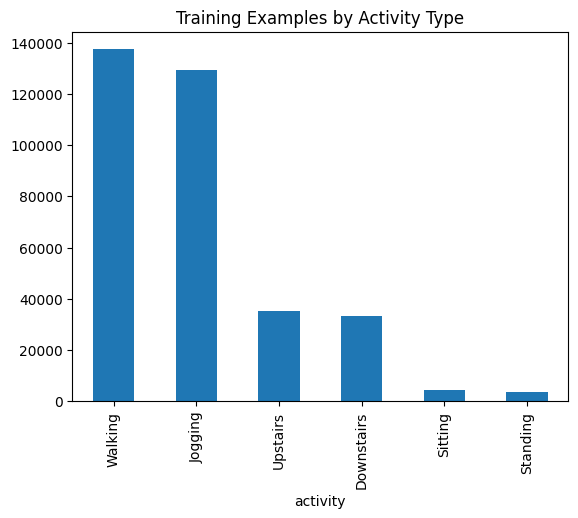

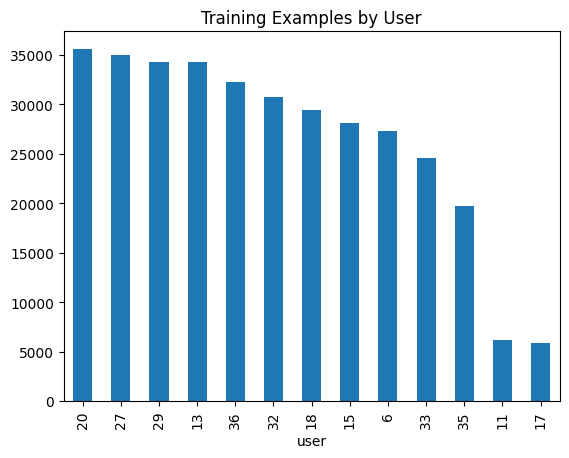

In [9]:
# Show how many training examples exist for each of the six activities
df["activity"].value_counts().plot(kind = "bar", title = "Training Examples by Activity Type")
plt.show()
# Better understand how the recordings are spread across the different users who participated in the study
df["user"].value_counts().plot(kind = "bar", title = "Training Examples by User")
plt.show()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343416 entries, 0 to 343415
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user      343416 non-null  object
 1   activity  343416 non-null  object
 2   time      343416 non-null  object
 3   x         343416 non-null  object
 4   y         343416 non-null  object
 5   z         343416 non-null  object
dtypes: object(6)
memory usage: 15.7+ MB


#### Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨

In [11]:
df['x'] = df['x'].astype('float')
df['y'] = df['y'].astype('float')
df['z'] = df['z'].astype('float')

In [12]:
# activity Ïª¨ÎüºÏóê Ï°¥Ïû¨ÌïòÎäî Í∞Å Í≥†Ïú†Í∞íÏùò Î™©Î°ù Í∞ÄÏ†∏Ïò§Í∏∞
activities = df['activity'].value_counts().index

In [13]:
label = LabelEncoder()
df['activity'] = label.fit_transform(df['activity'])
df.head()

user  activity            time         x          y         z
0   33         1  49105962326000 -0.694638  12.680544  0.503953
1   33         1  49106062271000  5.012288  11.264028  0.953424
2   33         1  49106112167000  4.903325  10.882658 -0.081722
3   33         1  49106222305000 -0.612916  18.496431  3.023717
4   33         1  49106332290000 -1.184970  12.108489  7.205164

In [14]:
activities

Index(['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing'], dtype='object', name='activity')

In [15]:
num_classes = 6

In [16]:
X = df[['x', 'y', 'z']]
y = df['activity']

In [17]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

scaled_X = pd.DataFrame(data = X, columns = ['x', 'y', 'z'])
scaled_X['label'] = y.values

scaled_X

x         y         z  label
0      -0.258214  0.697059  0.044419      1
1       0.607502  0.483225  0.145310      1
2       0.590972  0.425654 -0.087046      1
3      -0.245817  1.575011  0.610023      1
4      -0.332596  0.610703  1.548620      1
...          ...       ...       ...    ...
343411 -0.105815  0.402609 -0.059530      5
343412  0.265839  0.435820  0.120852      5
343413 -0.031484  0.315054  0.230915      5
343414 -0.391003  0.094656  0.249259      5
343415 -0.541182  0.078050  0.353208      5

[343416 rows x 4 columns]

In [18]:
# hop_sizeÎ•º frame_size Î≥¥Îã§ ÏûëÍ≤å ÏÑ§Ï†ïÌïòÏó¨ Ï§ëÎ≥µÎêú Ï†ïÎ≥¥Î•º Í≥†Î†§Ìï† Ïàò ÏûàÍ≤å Ìï® (Ïò§Î≤ÑÎûòÌïë)
Fs = 20
frame_size = Fs*4 # 80
hop_size = Fs*2 # 40

In [21]:
def get_frames(df, frame_size, hop_size):
  """
  ÏãúÍ≥ÑÏó¥ Îç∞Ïù¥ÌÑ∞Î•º CNNÏù¥ Ïù¥Ìï¥Ìï† Ïàò ÏûàÍ≤å Ïû¨Íµ¨ÏÑ±Ìï®.
  x,y,z Í∞íÏùÑ Í∞ÅÍ∞ÅÏùò Ï±ÑÎÑêÎ°ú ÎÇòÎàÑÍ≥†
  Ïó∞ÏÜçÏ†ÅÏù∏ Îç∞Ïù¥ÌÑ∞Î•º ÎèÖÎ¶ΩÏ†ÅÏù∏ Ïó¨Îü¨Í∞úÏùò Îç∞Ïù¥ÌÑ∞Î°ú ÎÇòÎàî (Ïä¨ÎùºÏù¥Îî© ÏúàÎèÑÏö∞ Î∂ÑÌï†).
  Ïù¥Îäî Í≥†Ï†ïÎêú Í∏∏Ïù¥Ïùò ÏûÖÎ†•Îßå Î∞õÏùÑ Ïàò ÏûàÎäî CNN ÌäπÏÑ±ÏóêÏÑú Í∏∞Ïù∏Ìï®.

  Args:
    df: Îç∞Ïù¥ÌÑ∞ ÌîÑÎ†àÏûÑ
    frame_size: Ïä¨ÎùºÏù¥Îî© ÏúàÎèÑÏö∞ Î∂ÑÌï† ÏÇ¨Ïù¥Ï¶à
    hop_size: Ïä¨ÎùºÏù¥Îî© ÏúàÎèÑÏö∞ ÏÇ¨Ïù¥Ï¶à

  Returns:
    frames: Î∂ÑÌï†Îêú Îç∞Ïù¥ÌÑ∞
    labels: Î∂ÑÌï†Îêú Îç∞Ïù¥ÌÑ∞Ïùò Î†àÏù¥Î∏î
  """

  N_FEATURES = 3

  frames = []
  labels = []
  for i in range(0, len(df) - frame_size, hop_size):
      x = df['x'].values[i: i + frame_size]
      y = df['y'].values[i: i + frame_size]
      z = df['z'].values[i: i + frame_size]

      # Retrieve the most often used label in this segment
      label = df['label'][i: i + frame_size].mode()[0]
      frames.append([x, y, z])
      labels.append(label)

  # Bring the segments into a better shape
  frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
  labels = np.asarray(labels)

  return frames, labels

In [22]:
X, y = get_frames(scaled_X, frame_size, hop_size)

In [23]:
X.shape, y.shape

((8584, 80, 3), (8584,))

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6867, 80, 3), (1717, 80, 3), (6867,), (1717,))

In [25]:
X_train[0].shape, X_test[0].shape

((80, 3), (80, 3))

In [26]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# 1D CNN Î™®Îç∏Ïùò ÏûÖÎ†• ÌòïÌÉúÏóê ÎßûÍ≤å ÌÖêÏÑú Ï∞®Ïõê Î≥ÄÍ≤Ω
# PyTorchÏùò nn.Conv1dÎäî (Î∞∞Ïπò ÌÅ¨Í∏∞, Ï±ÑÎÑê Ïàò, ÏãúÌÄÄÏä§ Í∏∏Ïù¥) ÌòïÌÉúÎ•º Í∏∞ÎåÄ
# ÌòÑÏû¨ Îç∞Ïù¥ÌÑ∞Îäî (Î∞∞Ïπò ÌÅ¨Í∏∞, ÏãúÌÄÄÏä§ Í∏∏Ïù¥, Ï±ÑÎÑê Ïàò) ÌòïÌÉúÏù¥ÎØÄÎ°ú, permuteÎ°ú Ï∞®ÏõêÏùÑ Î≥ÄÍ≤Ω
X_train_tensor = X_train_tensor.permute(0, 2, 1)
X_test_tensor = X_test_tensor.permute(0, 2, 1)

print("--- PyTorch ÌÖêÏÑúÎ°ú Î≥ÄÌôò ÌõÑ ÌòïÌÉú ---")
print(f"X_train ÌÖêÏÑúÏùò ÌòïÌÉú: {X_train_tensor.shape}")
print(f"y_train ÌÖêÏÑúÏùò ÌòïÌÉú: {y_train_tensor.shape}")
print(f"X_test ÌÖêÏÑúÏùò ÌòïÌÉú: {X_test_tensor.shape}")
print(f"y_test ÌÖêÏÑúÏùò ÌòïÌÉú: {y_test_tensor.shape}")

--- PyTorch ÌÖêÏÑúÎ°ú Î≥ÄÌôò ÌõÑ ÌòïÌÉú ---
X_train ÌÖêÏÑúÏùò ÌòïÌÉú: torch.Size([6867, 3, 80])
y_train ÌÖêÏÑúÏùò ÌòïÌÉú: torch.Size([6867])
X_test ÌÖêÏÑúÏùò ÌòïÌÉú: torch.Size([1717, 3, 80])
y_test ÌÖêÏÑúÏùò ÌòïÌÉú: torch.Size([1717])


#### Î™®Îç∏ Ï†ïÏùò Î∞è ÌõàÎ†®

In [27]:
class CNN1D(nn.Module):
    """
    1D CNN Î™®Îç∏ ÏïÑÌÇ§ÌÖçÏ≤ò Ï†ïÏùò.
    """
    def __init__(self, input_channels, num_classes):
        """
        Î™®Îç∏Ïùò Î†àÏù¥Ïñ¥Îì§ÏùÑ Ï¥àÍ∏∞ÌôîÌï©ÎãàÎã§.
        :param input_channels: ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞Ïùò Ï±ÑÎÑê Ïàò (Í∞ÄÏÜçÎèÑÍ≥ÑÏùò x, y, zÏ∂ïÏù¥ÎØÄÎ°ú 3)
        :param num_classes: Î∂ÑÎ•òÌï† ÌÅ¥ÎûòÏä§Ïùò Ï¥ù Í∞úÏàò
        """
        super(CNN1D, self).__init__()

        # 1. Ìï©ÏÑ±Í≥± Î†àÏù¥Ïñ¥ (Convolutional Layers)
        # ÏãúÍ≥ÑÏó¥ Îç∞Ïù¥ÌÑ∞Ïùò ÌäπÏßïÏùÑ Ï∂îÏ∂úÌïòÎäî Ïó≠Ìï†
        self.conv_layers = nn.Sequential(
            # Ï≤´ Î≤àÏß∏ Ìï©ÏÑ±Í≥± Î†àÏù¥Ïñ¥
            # ÏûÖÎ†• Ï±ÑÎÑê 3 -> Ï∂úÎ†• Ï±ÑÎÑê 64
            # Ïª§ÎÑê ÏÇ¨Ïù¥Ï¶à 3, Ìå®Îî© 1Î°ú ÏãúÌÄÄÏä§ Í∏∏Ïù¥ Ïú†ÏßÄ
            nn.Conv1d(input_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),  # ÏãúÌÄÄÏä§ Í∏∏Ïù¥Î•º Ï†àÎ∞òÏúºÎ°ú Ï§ÑÏûÑ

            # Îëê Î≤àÏß∏ Ìï©ÏÑ±Í≥± Î†àÏù¥Ïñ¥
            # ÏûÖÎ†• Ï±ÑÎÑê 64 -> Ï∂úÎ†• Ï±ÑÎÑê 128
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)   # ÏãúÌÄÄÏä§ Í∏∏Ïù¥Î•º Îã§Ïãú Ï†àÎ∞òÏúºÎ°ú Ï§ÑÏûÑ
        )

        # 2. Ìï©ÏÑ±Í≥± Î†àÏù¥Ïñ¥Ïùò Ï∂úÎ†• ÌÅ¨Í∏∞ Í≥ÑÏÇ∞
        # Îã§Ïùå ÏôÑÏ†Ñ Ïó∞Í≤∞ Î†àÏù¥Ïñ¥Ïùò ÏûÖÎ†• ÌÅ¨Í∏∞Î•º ÏûêÎèôÏúºÎ°ú Í≥ÑÏÇ∞
        self._to_linear = self._calculate_conv_output(input_channels)

        # 3. Î∂ÑÎ•òÍ∏∞ (Classifier)
        # Ï∂îÏ∂úÎêú ÌäπÏßïÏùÑ Í∏∞Î∞òÏúºÎ°ú ÏµúÏ¢Ö Î∂ÑÎ•òÎ•º ÏàòÌñâ
        self.classifier = nn.Sequential(
            nn.Linear(self._to_linear, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)  # ÏµúÏ¢Ö Ï∂úÎ†• ÎÖ∏ÎìúÎäî ÌÅ¥ÎûòÏä§ ÏàòÏôÄ ÎèôÏùº
        )

    def _calculate_conv_output(self, input_channels):
        """
        ÎçîÎØ∏ ÏûÖÎ†•ÏúºÎ°ú Ìï©ÏÑ±Í≥± Î†àÏù¥Ïñ¥Ïùò ÏµúÏ¢Ö Ï∂úÎ†• ÌÅ¨Í∏∞Î•º Í≥ÑÏÇ∞ÌïòÎäî Ìó¨Ìçº Î©îÏÑúÎìú
        """
        # (1, ÏûÖÎ†• Ï±ÑÎÑê, ÏãúÌÄÄÏä§ Í∏∏Ïù¥) ÌòïÌÉúÏùò ÎçîÎØ∏ ÌÖêÏÑú ÏÉùÏÑ±
        dummy_input = torch.zeros(1, input_channels, 80)
        output = self.conv_layers(dummy_input)

        # Ï∂úÎ†• ÌÖêÏÑúÏùò Î™®Îì† ÏöîÏÜå ÏàòÎ•º Í≥±ÌïòÏó¨ ÌÅ¨Í∏∞ Î∞òÌôò
        return int(np.prod(output.shape))

    def forward(self, x):
        """
        ÏàúÏ†ÑÌåå(Forward Pass) Í≥ºÏ†ï Ï†ïÏùò
        :param x: Î™®Îç∏Ïùò ÏûÖÎ†• ÌÖêÏÑú. ÌòïÌÉú: (Î∞∞Ïπò ÌÅ¨Í∏∞, Ï±ÑÎÑê Ïàò, ÏãúÌÄÄÏä§ Í∏∏Ïù¥)
        """
        # Ìï©ÏÑ±Í≥± Î†àÏù¥Ïñ¥Î•º ÌÜµÍ≥º
        x = self.conv_layers(x)

        # ÏôÑÏ†Ñ Ïó∞Í≤∞ Î†àÏù¥Ïñ¥Ïóê ÎÑ£Í∏∞ ÏúÑÌï¥ ÌÖêÏÑúÎ•º 1Ï∞®ÏõêÏúºÎ°ú ÌéºÏπ®
        x = x.view(x.size(0), -1)

        # Î∂ÑÎ•òÍ∏∞ Î†àÏù¥Ïñ¥Î•º ÌÜµÍ≥ºÌïòÏó¨ ÏµúÏ¢Ö ÏòàÏ∏°Í∞í Î∞òÌôò
        x = self.classifier(x)
        return x


In [40]:
model = CNN1D(input_channels=3, num_classes=6)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNN1D(
  (conv_layers): Sequential(
    (0): Conv1d(3, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=2560, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=6, bias=True)
  )
)

In [41]:
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



# 3. ÌõàÎ†® Î£®ÌîÑ
epochs = 25
train_losses = []
test_losses = []
test_accuracies = []

for epoch in range(epochs):
    # ÌõàÎ†® Î™®Îìú ÏÑ§Ï†ï
    model.train()
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(train_loader):
        # inputsÏôÄ labelsÎ•º GPUÎ°ú ÏòÆÍ∏∞Í∏∞ (GPU ÏÇ¨Ïö© Ïãú)

        inputs, labels = inputs.to(device), labels.to(device)

        # Í∏∞Ïö∏Í∏∞ Ï¥àÍ∏∞Ìôî
        optimizer.zero_grad()

        # ÏàúÏ†ÑÌåå
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Ïó≠Ï†ÑÌåå Î∞è Í∞ÄÏ§ëÏπò ÏóÖÎç∞Ïù¥Ìä∏
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # 4. Í≤ÄÏ¶ù Î£®ÌîÑ
    model.eval()
    running_test_loss = 0.0
    all_predictions = []
    all_labels = []

    with torch.no_grad(): # Í∏∞Ïö∏Í∏∞ Í≥ÑÏÇ∞ ÎπÑÌôúÏÑ±Ìôî
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_test_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = running_test_loss / len(test_loader.dataset)
    test_accuracy = accuracy_score(all_labels, all_predictions)

    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"Epoch [{epoch+1}/{epochs}], "
          f"Train Loss: {train_loss:.4f}, "
          f"Test Loss: {test_loss:.4f}, "
          f"Test Accuracy: {test_accuracy*100:.2f}%")

Epoch [1/25], Train Loss: 0.9259, Test Loss: 0.6239, Test Accuracy: 79.97%
Epoch [2/25], Train Loss: 0.5561, Test Loss: 0.5058, Test Accuracy: 82.24%
Epoch [3/25], Train Loss: 0.4647, Test Loss: 0.4373, Test Accuracy: 84.16%
Epoch [4/25], Train Loss: 0.4062, Test Loss: 0.3925, Test Accuracy: 85.73%
Epoch [5/25], Train Loss: 0.3653, Test Loss: 0.3603, Test Accuracy: 87.25%
Epoch [6/25], Train Loss: 0.3326, Test Loss: 0.3319, Test Accuracy: 87.48%
Epoch [7/25], Train Loss: 0.3005, Test Loss: 0.3003, Test Accuracy: 88.99%
Epoch [8/25], Train Loss: 0.2748, Test Loss: 0.2813, Test Accuracy: 91.38%
Epoch [9/25], Train Loss: 0.2529, Test Loss: 0.2714, Test Accuracy: 90.91%
Epoch [10/25], Train Loss: 0.2320, Test Loss: 0.2442, Test Accuracy: 92.14%
Epoch [11/25], Train Loss: 0.2145, Test Loss: 0.2280, Test Accuracy: 92.31%
Epoch [12/25], Train Loss: 0.2047, Test Loss: 0.2287, Test Accuracy: 92.20%
Epoch [13/25], Train Loss: 0.1805, Test Loss: 0.2102, Test Accuracy: 92.72%
Epoch [14/25], Train 

In [43]:
def plot_learningCurve_pytorch(train_losses, test_losses, test_accuracies, epochs):
    """
    PyTorch Î™®Îç∏Ïùò ÌïôÏäµ Í≥°ÏÑ†ÏùÑ ÏãúÍ∞ÅÌôîÌïòÎäî Ìï®Ïàò.

    :param train_losses: ÏóêÌè≠Î≥Ñ ÌõàÎ†® ÏÜêÏã§(loss) Î¶¨Ïä§Ìä∏
    :param test_losses: ÏóêÌè≠Î≥Ñ Í≤ÄÏ¶ù ÏÜêÏã§(loss) Î¶¨Ïä§Ìä∏
    :param test_accuracies: ÏóêÌè≠Î≥Ñ Í≤ÄÏ¶ù Ï†ïÌôïÎèÑ(accuracy) Î¶¨Ïä§Ìä∏
    :param epochs: Ï¥ù ÏóêÌè≠ Ïàò
    """
    epoch_range = range(1, epochs + 1)

    # Ï†ïÌôïÎèÑ(Accuracy) Í∑∏ÎûòÌîÑ
    plt.plot(epoch_range, test_accuracies, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

    # ÏÜêÏã§(Loss) Í∑∏ÎûòÌîÑ
    plt.plot(epoch_range, train_losses, label='Train Loss')
    plt.plot(epoch_range, test_losses, label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

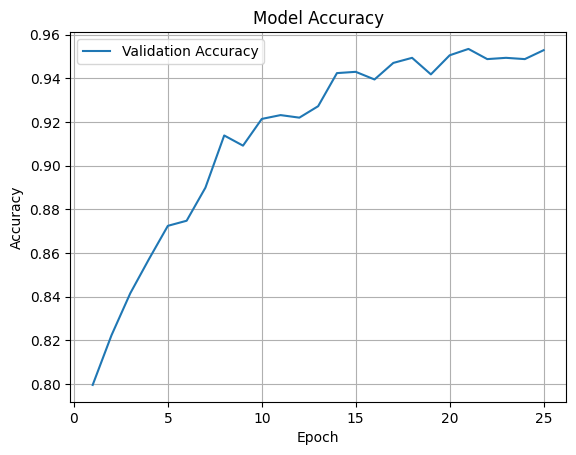

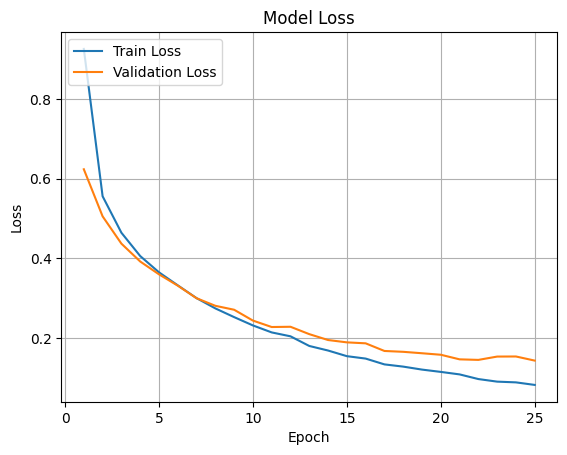

In [44]:
plot_learningCurve_pytorch(train_losses, test_losses, test_accuracies, epochs)

#### Î™®Îç∏ ÌèâÍ∞Ä

In [45]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import torch

# device Ï†ïÏùò (Ïù¥ÎØ∏ ÏΩîÎìú ÏÉÅÎã®Ïóê ÏûàÎã§Î©¥ ÏÉùÎûµ Í∞ÄÎä•)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the model to evaluation mode
model.eval()

# Perform prediction (model.predict equivalent)
with torch.no_grad():
    # üí° X_test_tensorÎ•º Î™®Îç∏Í≥º Í∞ôÏùÄ deviceÎ°ú Î≥¥ÎÉÖÎãàÎã§.
    y_pred_test = model(X_test_tensor.to(device))

# Get the predicted class (highest probability)
# GPUÏóê ÏûàÎäî ÏòàÏ∏° Í≤∞Í≥ºÎ•º CPUÎ°ú Îã§Ïãú Í∞ÄÏ†∏ÏôÄÏÑú numpyÎ°ú Î≥ÄÌôòÌï¥Ïïº Ìï©ÎãàÎã§.
y_pred_classes = torch.argmax(y_pred_test, dim=1).cpu().numpy()

# Get the true labels
y_true = y_test_tensor.cpu().numpy()

# Print the classification report
print("### Classification Report ###")
print(classification_report(y_true, y_pred_classes))

# Print the confusion matrix
print("\n### Confusion Matrix ###")
print(confusion_matrix(y_true, y_pred_classes))

### Classification Report ###
              precision    recall  f1-score   support

           0       0.93      0.77      0.84       167
           1       0.97      0.99      0.98       646
           2       1.00      0.91      0.95        23
           3       1.00      0.94      0.97        18
           4       0.82      0.84      0.83       176
           5       0.97      0.99      0.98       687

    accuracy                           0.95      1717
   macro avg       0.95      0.91      0.93      1717
weighted avg       0.95      0.95      0.95      1717


### Confusion Matrix ###
[[129   4   0   0  25   9]
 [  0 640   0   0   1   5]
 [  0   0  21   0   2   0]
 [  0   0   0  17   1   0]
 [  9  13   0   0 147   7]
 [  1   0   0   0   4 682]]


(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

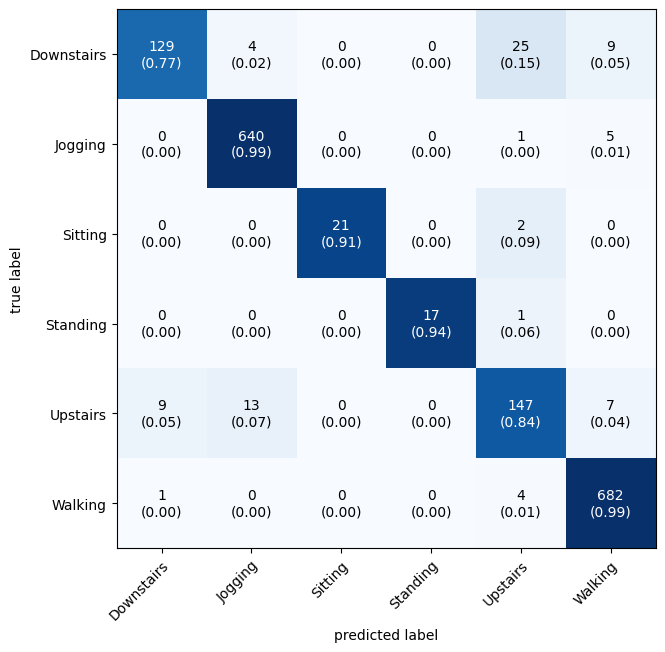

In [46]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# device Ï†ïÏùò (Ïù¥ÎØ∏ ÏΩîÎìú ÏÉÅÎã®Ïóê ÏûàÎã§Î©¥ ÏÉùÎûµ Í∞ÄÎä•)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.eval()

# with torch.no_grad()Î•º ÏÇ¨Ïö©ÌïòÏó¨ Í∏∞Ïö∏Í∏∞ Í≥ÑÏÇ∞ÏùÑ ÎπÑÌôúÏÑ±ÌôîÌï©ÎãàÎã§.
with torch.no_grad():
    # üí° X_test_tensorÎ•º Î™®Îç∏Í≥º Í∞ôÏùÄ deviceÎ°ú Î≥¥ÎÉÖÎãàÎã§.
    predicted = model(X_test_tensor.to(device))

# ÏòàÏ∏° Í≤∞Í≥ºÎ•º CPUÎ°ú Í∞ÄÏ†∏Ïò® ÌõÑ NumPy Î∞∞Ïó¥Î°ú Î≥ÄÌôòÌï©ÎãàÎã§.
y_pred = torch.argmax(predicted, dim=1).cpu().numpy()

# Ïã§Ï†ú ÎùºÎ≤®ÏùÑ NumPy Î∞∞Ïó¥Î°ú Î≥ÄÌôò
y_true = y_test_tensor.cpu().numpy()

# scikit-learnÏùÑ ÏÇ¨Ïö©ÌïòÏó¨ ÌòºÎèô ÌñâÎ†¨ ÏÉùÏÑ±
mat = confusion_matrix(y_true, y_pred)

# mlxtendÎ•º ÏÇ¨Ïö©ÌïòÏó¨ ÌòºÎèô ÌñâÎ†¨ ÏãúÍ∞ÅÌôî
plot_confusion_matrix(
    conf_mat=mat,
    class_names=label.classes_,  # LabelEncoderÏóê Ï†ÄÏû•Îêú ÌÅ¥ÎûòÏä§ Ïù¥Î¶Ñ ÏÇ¨Ïö©
    show_normed=True,
    figsize=(7, 7)
)